# Collision Detection
Here we test our collision detection approaches: sampling based vs theoretical bounds

[(0, 1), (1, 0)]
car 0: line 2
The value is   0.6425097810977508
____
car 0: line 3
The value is   0.13627124731467183
____
sum per car =  0.7787810284124226
diff =  0.22121897158757742
++++++++++++++
car 1: line 2
The value is   0.893223553937504
____
car 1: line 3
The value is   0.024082716753014266
____
sum per car =  0.9173062706905182
diff =  0.08269372930948182
++++++++++++++
###################
Paper bound:   0.08269372930948182
# terms =  4
______________________
sample prob =  0.009600000000000053


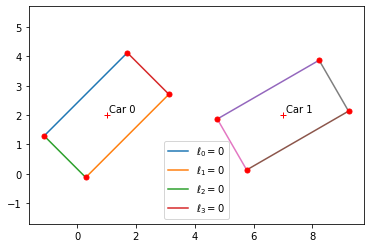

In [507]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload
import collision as c
reload(c)


cov = np.array([[1,0], [0,1]])
c1 = c.car(theta=np.pi/4, W=2, L=4, bx=1, by=2,cov=cov, name= "Car 0")
c2 = c.car(theta=np.pi/6, W=2, L=4, bx=7, by=2,cov=cov, name= "Car 1")
c1.plot(show_line_labels=True)
c2.plot()


# idx = [[(0,1),(1,0)], [(0,0), (1,1)], [(0,2), (1,3)], [(0,3),(0,2)]] 
# truth = c.prob_collision(c1,c2,sample_size = 10000, idx=idx)
idx = [[(0,1),(1,0)]]
truth = c.prob_collision(c1,c2,sample_size = 10000, idx=idx, violate_lines=[(0,2),(0,3),(1,2),(1,3)])
# truth = c.prob_collision(c1,c2,sample_size = 1000)

                    
c.prob_collision_upper_bound(c1,c2)

print("______________________")
print("sample prob = ", truth)



# sel_points = c.select_collision_points(c1,c2,idx=[[(0,1),(1,0)]], violate_lines=[(0,2), (0,3)] )
# c1.plot_sample(show_line_labels=True,color=None)
# c2.plot_sample(color="blue")
# for p in sel_points:
#     plt.plot([p[0]], [p[1]], marker='o', markersize=15, color="black")

## Candidate Collision points 
The blue dots below represent candidate collision points (an intersection between any pair of lines). Red dots can be seen by adjusting the location of the two cars. these represent actual collision points.


# of candidate points =  16
# of collision points =  0
Collision:  False


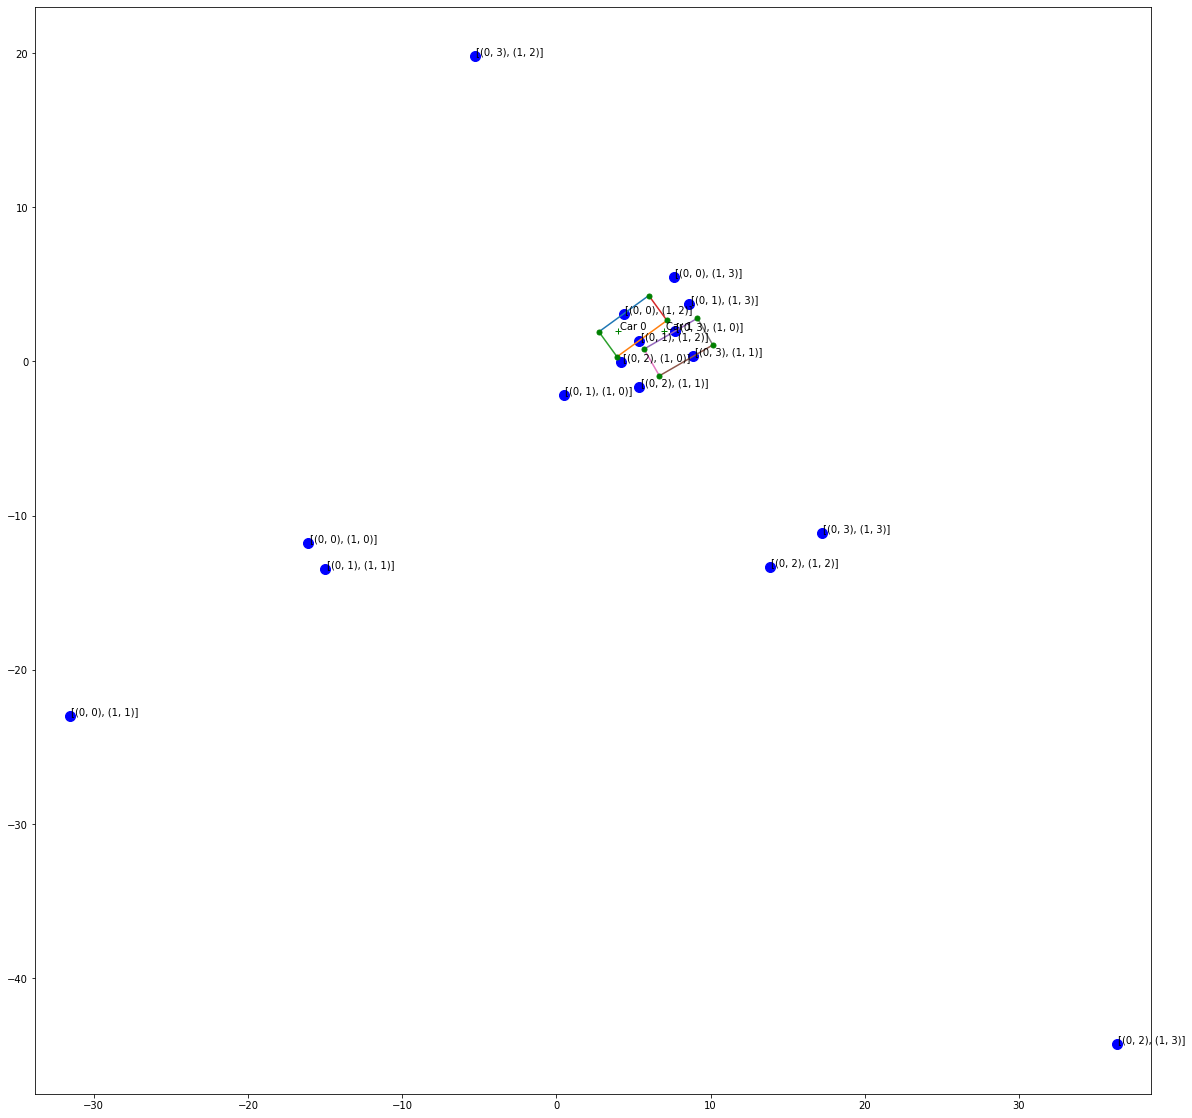

In [408]:
fig= plt.figure(figsize=(20,20))

points, idx = c._candidate_collision_points(c1,c2)
for p,i in zip(points, idx):
    plt.plot([p[0]], [p[1]], marker='o', markersize=10, color="blue")
    plt.text(p[0]+.1, p[1]+.1, str(i))
c1.plot(color="green")
c2.plot(color="green")
print("# of candidate points = ", len(points))

col_points = c.collision_points(c1,c2)
print("# of collision points = ", len(col_points))
for p in col_points:
    plt.plot([p[0]], [p[1]], marker='o', markersize=10, color="red")

    
print("Collision: ", c.test_collision(c1,c2))

# Sampling based

# of candidate points =  2
# of collision points =  0


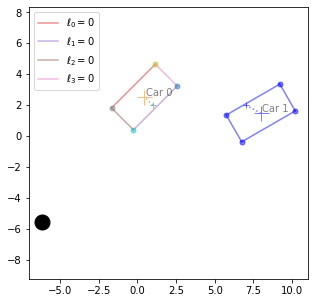

In [546]:
fig= plt.figure(figsize=(5,5))

c1.sample()
c1.plot_sample(alpha=.5, show_line_labels=True, color=None)
c2.sample()
c2.plot_sample(alpha=.5,color="blue")
points = c._candidate_collision_points(c1,c2)
print("# of candidate points = ", len(points))

col_points = c.collision_points(c1,c2)
print("# of collision points = ", len(col_points))

for p in col_points:
    plt.plot([p[0]], [p[1]], marker='o', markersize=10, color="red")

    
    
sel_points = c.select_collision_points(c1,c2,idx=[[(0,1),(1,0)]], violate_lines=[(0,2)] )

for p in sel_points:
    plt.plot([p[0]], [p[1]], marker='o', markersize=15, color="black")

In [35]:
import time

# t1 = time.clock()
print("Probability of collision ~", c.prob_collision(c1,c2, sample_size=10000))

# print(time.clock()-t1)

# c.prob_collision(c1,c2,sample_size = 10000, idx=[[(0,1),(1,0)]], for_vehicle=None)

Probability of collision ~ 0.541


## Plot $n$ samples along with collisions
Collisions are shown as black dots

Num Collision Cases =  5  ~ Pr(Collision) =  0.5


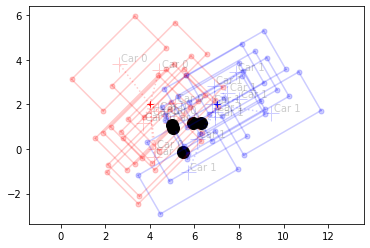

In [60]:
count = 0
sample_size = 10
for i in range(sample_size):
    c1.sample()
    c2.sample()
    c1.plot_sample(alpha=.2)
    c2.plot_sample(alpha=.2, color="blue")
    col_points = c.collision_points(c1,c2)
    for p in col_points:
        plt.plot([p[0]], [p[1]], marker='o', markersize=12, color="black")
        count += 1
        break
print("Num Collision Cases = ", count, " ~ Pr(Collision) = ", count/sample_size)

# Other experiments

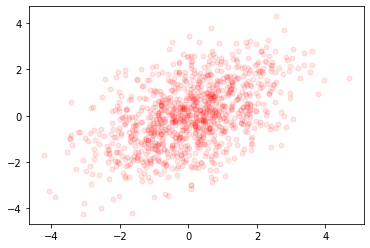

In [1014]:
for i in range(1000):
    r = np.random.multivariate_normal([0,0], [[2,1],[1,2]])  
    plt.plot([r[0]], [r[1]], marker='o', markersize=5, color="red", alpha=0.1)

## Note
It seems numpy multivariate sampling is much slower than single variate (we are talking about around **20x speed up!**). See the experiments below.

Below we test the distribution between two cases:
* sample a multi-variate variable $\omega=(\omega_x, \omega_y)$, then subsitute into $\gamma_k$
* sample $\gamma_k$ directly using its standard deviation as shown in Table 1 in the latex document

Both distributions look the same, experimentally asserting that our analysis is correct. However, the running time of the second approach is around $20$ times faster.

total sampling time: 1.1132989999989462


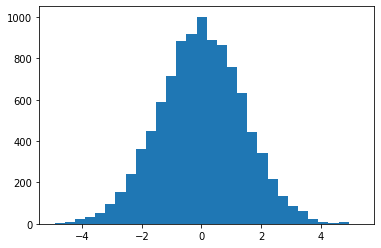

In [193]:
import time

cov = c1.cov
g1 = []
total1 = 0
for i in range(10000):
    t1=time.clock()
    omega = np.random.multivariate_normal([0, 0], cov)
    total1 += time.clock()-t1
    g1.append( - np.tan(c1.theta) * omega[0] + omega[1] )
    
print("total sampling time:", total1)
plt.hist(g1, bins=30);

total sampling time: 0.055481000000327185
Speed up factor: 18.590328220364437


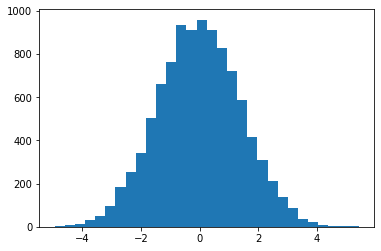

In [192]:
g2 = []
total2 = 0
for i in range(10000):
    t1=time.clock()
    gamma = np.random.normal(0, c1.std_gamma[0])
    total2 += time.clock()-t1
    g2.append( gamma )

plt.hist(g2, bins=30);

print("total sampling time:", total2)
print("Speed up factor:", total1/total2)